# Nobel Model

Tasks:

1. vytvorit fiktivni populaci milionu lidi (nebo vzit CR tak, jak je) data o vekove strukture jsou na CSU

2. rozjet simulaci, ktera necha lidi umirat (asi po celych tydnech) podle umrtnostnich krivek
data jsou tady
https://www.czso.cz/…_cr
tohle by melo vytvorit casove rady, ktere jsou zde
https://www.czso.cz/…_cr

3. je treba u toho nejak vyresit ze se lidi rodi, umiraji a starnou, ale to vse je na CSU

4. az pojede tento model a bude schopen replikovat ty realne ceske krivky
tak do toho domodelovat vakcinaci
data jsou tady
prikladam txt soubor s popisem vsechn otevrenych datovych sad, ktere ma UZIS
(prehled dat UZIS.txt)

5. v kazdem tydnu je treba nahodne vytahnbout spravny pocet lidi na umrti
a spravny pocet lidi na vakcinaci

6. a ted jde o to, jestli tyhle dva vybery budou nezavisle nebo ne.
v prvni fazi to prosim udelejme nezavisle
a potom vyzkousejme postupne zvysovat miru disjunktnosti techto dvou vyberu
az do te miry, ze nikdo, kdo ma tento tyden umrit, nebude ockovan

7. no a pak uz staci nakreslit tento typ dat
https://smis-lab.cz/2022/01/01/vakcinacni-voodoo/ a tento typ dat
https://smis-lab.cz/2021/12/25/umrti-dle-ockovaciho-statutu-v-roce-2021-data-zdravotnich-pojistoven/

In [1]:
from matplotlib import pyplot as plt
from common import *
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
sns.set_theme()

## Load data

In [3]:
df_deaths = pd.read_csv(DEATHS_FILE)
df_vacc = pd.read_csv(VACCINATION_FILE)
df_counts = pd.read_csv(COUNTS_FILE)

### Sanity checks

In [4]:
assert len(df_deaths) >= len(df_vacc.drop(columns="poradi_davky").groupby(["tyden", "vek"]).sum()), "Cropping applied?"
assert len(df_deaths["tyden"].unique()) == len(df_vacc["tyden"].unique()), "Weeks are not the same!"
assert len(df_deaths["vek"].unique()) == len(df_vacc["vek"].unique()) == len(df_counts["vek"].unique()), "Age groups are not the same!"

### Preview

In [144]:
df_deaths

,tyden,vek,umrti
0,2020-W52,0-29,48
1,2020-W52,30-39,54
2,2020-W52,40-49,138
3,2020-W52,50-59,336
4,2020-W52,60-69,856
...,...,...,...
730,2022-W51,30-39,46
731,2022-W51,40-49,172
732,2022-W51,50-59,300
733,2022-W51,60-69,684


In [6]:
df_vacc

,tyden,vek,poradi_davky,pocet_davek
0,2020-W52,0-29,1,169
1,2020-W52,30-39,1,235
2,2020-W52,40-49,1,347
3,2020-W52,50-59,1,258
4,2020-W52,60-69,1,180
...,...,...,...,...
2236,2022-W51,40-49,1,23
2237,2022-W51,40-49,2,19
2238,2022-W51,40-49,3,80
2239,2022-W51,40-49,4,364


In [7]:
df_counts

,vek,celkem
0,0-29,3259827
1,30-39,1409650
2,40-49,1735533
3,50-59,1354501
4,60-69,1284689
5,70-79,1037997
6,80-129,441970


## Preparations

In [118]:
data = {}
dose_unique = df_vacc["poradi_davky"].unique()
age_unique = df_deaths["vek"].unique()

for age in age_unique:
    data[age] = {}
    for dose in np.insert(dose_unique, 0, 0):
        data[age][dose] = {
            "count": df_counts[df_counts["vek"] == age].celkem.values[0] if dose == 0 else 0,
            "dead": 0,
        }

## Simulation

### Závislost výběru zemřelých
 - P = 0 vaccinated and normal people would be killed equally
 - P \> 0 vaccinated people do not want to die

In [119]:
P = 0.3
BIRTH_PER_WEEK = round(110_500 / 365.25 * 7)
BIRTH_CATEGORY = f"{AGE_CATEGORIES[0][0]}-{AGE_CATEGORIES[0][1]}"

In [120]:
x = [datetime.strptime(date + "-1", "%Y-W%W-%w") for date in df_deaths["tyden"].unique()]
y_death_vaccinated = {}
y_death_vaccinated_dead = {}
y_death_vaccinated_alive = {}
y_death_normal = {}
y_death_normal_dead = {}
y_death_normal_alive = {}

for row_death in tqdm(df_deaths.itertuples(), total=len(df_deaths)):
    # Give birth
    if row_death.vek == BIRTH_CATEGORY:
        data[BIRTH_CATEGORY][0]["count"] += BIRTH_PER_WEEK

    # Aging people
    for dose in data[row_death.vek]:
        age_index = np.where(age_unique == row_death.vek)[0][0]
        if age_index != 0:
            younger_age = age_unique[age_index - 1]
            younger_age_diff = int(younger_age.split("-")[1]) - int(younger_age.split("-")[0])

            count = round(7 / 365.25 / younger_age_diff * data[younger_age][dose]["count"])
            data[younger_age][dose]["count"] -= count
            data[row_death.vek][dose]["count"] += count

    # Vaccinate people
    for row_vacc in df_vacc[(df_vacc.tyden == row_death.tyden) & (df_vacc.vek == row_death.vek)].itertuples():
        data[row_death.vek][row_vacc.poradi_davky - 1]["count"] -= row_vacc.pocet_davek
        data[row_death.vek][row_vacc.poradi_davky]["count"] += row_vacc.pocet_davek

    total = sum(i["count"] for i in data[row_death.vek].values())
    death_ratio = row_death.umrti / total

    # Compute fractions by dose to kill
    parts = {}
    dose_0 = round(data[row_death.vek][0]["count"] * death_ratio)

    for k, v in reversed(data[row_death.vek].items()):
        if k == 0:
            parts[k] = dose_0
        else:
            parts[k] = round(v["count"] * death_ratio)

            remove = min(round(parts[k] * P), parts[k])
            if dose_0 + remove > data[row_death.vek][0]["count"]:
                print(f"Warning - Too many people want to die! ({dose_0 + remove}/{data[row_death.vek][0]['count']})")
                remove = data[row_death.vek][0]["count"] - dose_0

            assert remove >= 0, "Negative people count want to die!"
            dose_0 += remove
            parts[k] -= remove

    assert abs(sum(parts.values()) - row_death.umrti) <= 1

    # Kill people # TODO do this by random??
    total_dead = 0
    leave_to_other = 0
    for k, v in reversed(sorted(parts.items())):
        # Round error protection - everytime is killed exact count of people
        if k == 0:
            current_amount = row_death.umrti - total_dead
        else:
            current_amount = v + leave_to_other

        # If not enough people, people with lower dose count will die
        if data[row_death.vek][k]["count"] < current_amount:
            leave_to_other = current_amount - data[row_death.vek][k]["count"]
            current_amount = data[row_death.vek][k]["count"]
        else:
            leave_to_other = 0

        total_dead += current_amount

        data[row_death.vek][k]["count"] -= current_amount
        data[row_death.vek][k]["dead"] += current_amount

        assert data[row_death.vek][k]["count"] >= 0, "Negative people count"  # Probably just useless
    assert leave_to_other == 0, f"Not enough people, date {row_death.tyden}, age {row_death.vek}"

    # For visualization
    y_death_normal.setdefault(row_death.vek, []).append(current_amount / data[row_death.vek][0]["count"] * 100_000)
    y_death_normal_dead.setdefault(row_death.vek, []).append(current_amount)
    y_death_normal_alive.setdefault(row_death.vek, []).append(data[row_death.vek][0]["count"])

    dead_count = total_dead - current_amount
    alive_count = sum(v["count"] for k, v in data[row_death.vek].items() if k != 0)
    y_death_vaccinated.setdefault(row_death.vek, []).append(dead_count / alive_count * 100_000)
    y_death_vaccinated_dead.setdefault(row_death.vek, []).append(dead_count)
    y_death_vaccinated_alive.setdefault(row_death.vek, []).append(alive_count)

100%|██████████| 735/735 [00:00<00:00, 1953.52it/s]


## Graphs

### Mrtví na 100 000

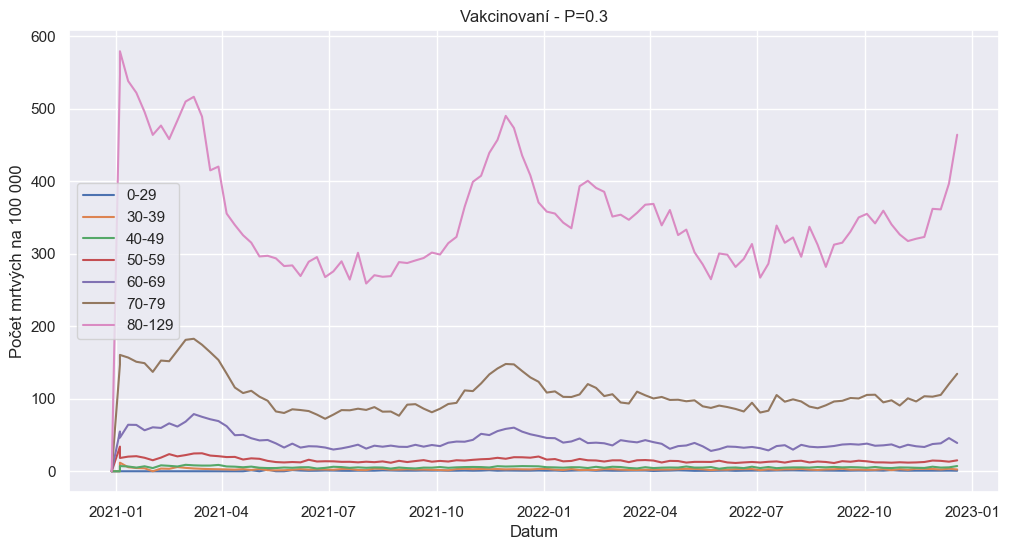

In [121]:
plt.figure(figsize=(12, 6))
for age, values in y_death_vaccinated.items():
    plt.plot(x, values, label=age)

plt.ylabel("Počet mrtvých na 100 000")
plt.xlabel("Datum")
plt.title(f"Vakcinovaní - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_100000_vaccinated.png");

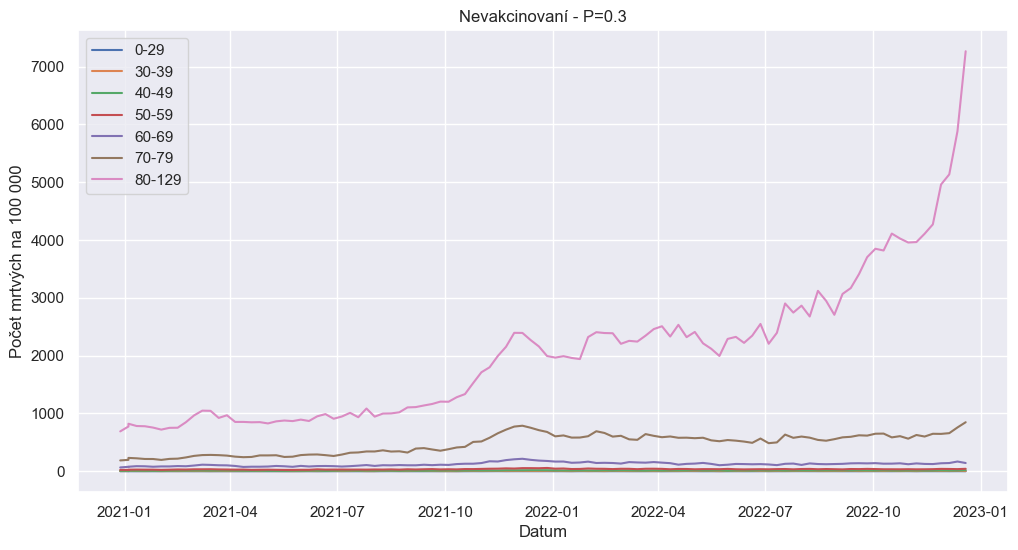

In [122]:
plt.figure(figsize=(12, 6))
for age, values in y_death_normal.items():
    plt.plot(x, values, label=age)

plt.ylabel("Počet mrtvých na 100 000")
plt.xlabel("Datum")
plt.title(f"Nevakcinovaní - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_100000_normal.png");

### Mrtví

In [123]:
# Sanity check
simulation_deaths = round(sum([sum(i) for i in y_death_vaccinated_dead.values()]) + sum([sum(i) for i in y_death_normal_dead.values()]))
assert simulation_deaths == df_deaths["umrti"].sum()

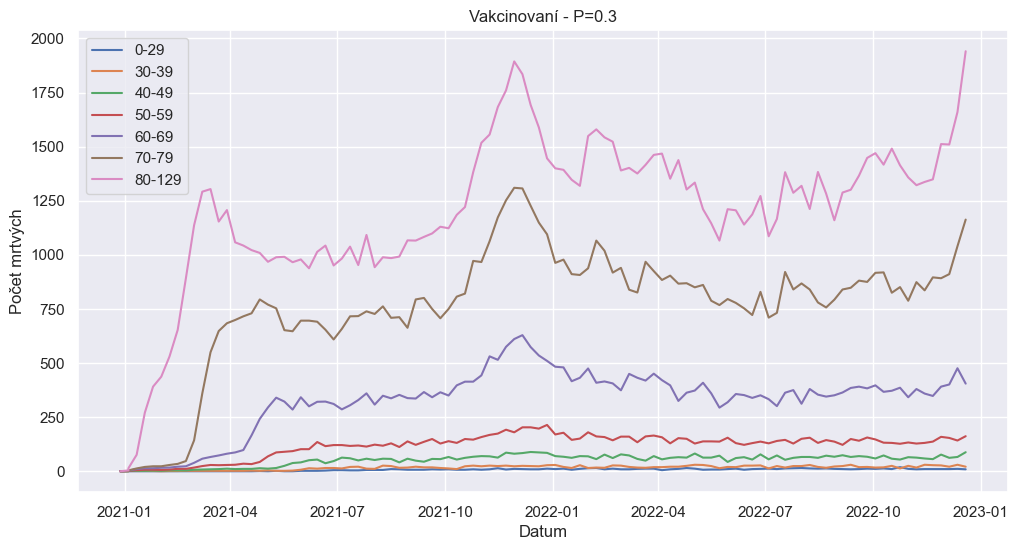

In [124]:
plt.figure(figsize=(12, 6))
for age, values in y_death_vaccinated_dead.items():
    plt.plot(x, values, label=age)

plt.ylabel("Počet mrtvých")
plt.xlabel("Datum")
plt.title(f"Vakcinovaní - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_dead_vaccinated.png");

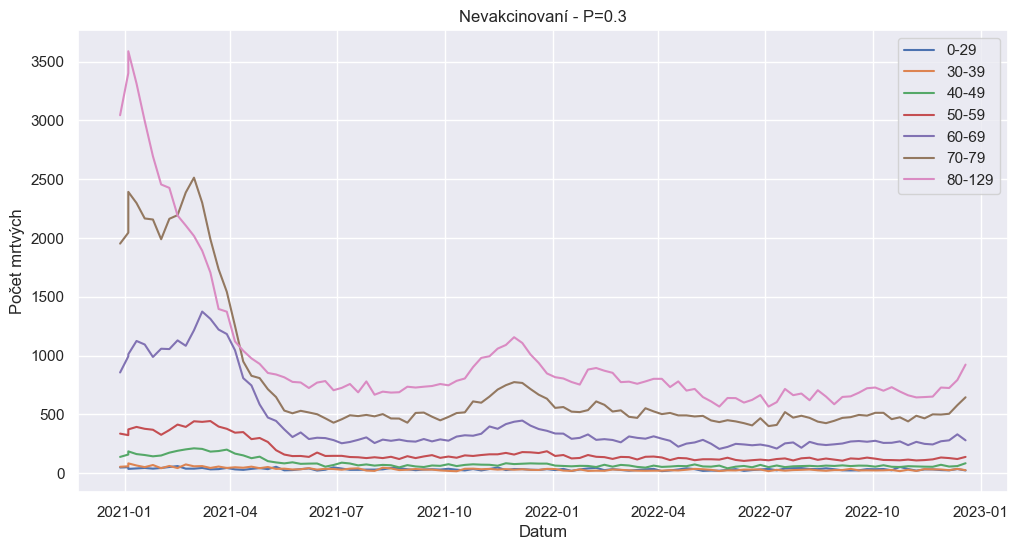

In [125]:
plt.figure(figsize=(12, 6))
for age, values in y_death_normal_dead.items():
    plt.plot(x, values, label=age)

plt.ylabel("Počet mrtvých")
plt.xlabel("Datum")
plt.title(f"Nevakcinovaní - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_dead_normal.png");

### Živí

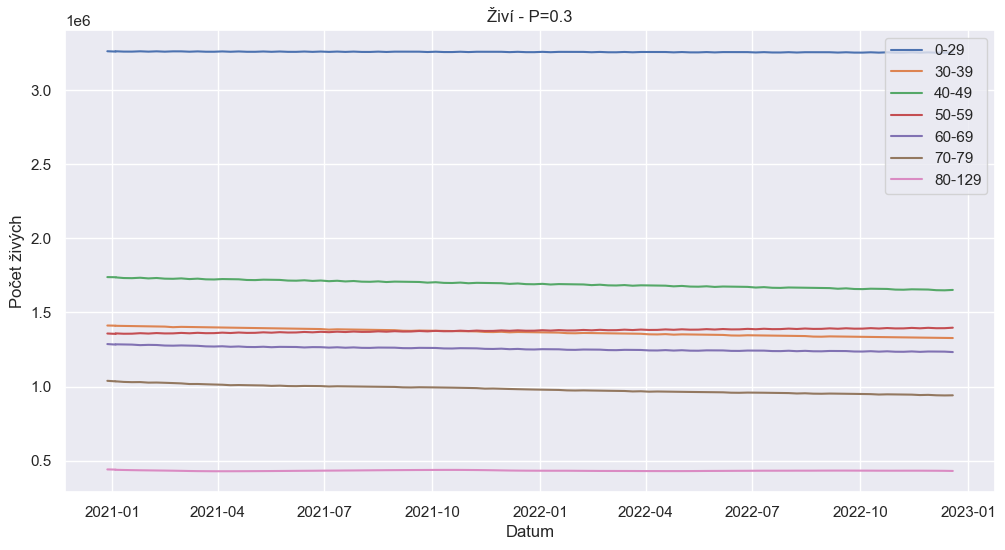

In [126]:
plt.figure(figsize=(12, 6))
for (age1, values1), (age2, values2) in zip(y_death_vaccinated_alive.items(), y_death_normal_alive.items()):
    assert age1 == age2, "Age groups do not match"
    plt.plot(x, np.array(values1) + np.array(values2), label=age1)

plt.ylabel("Počet živých")
plt.xlabel("Datum")
plt.title(f"Živí - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_alive.png");

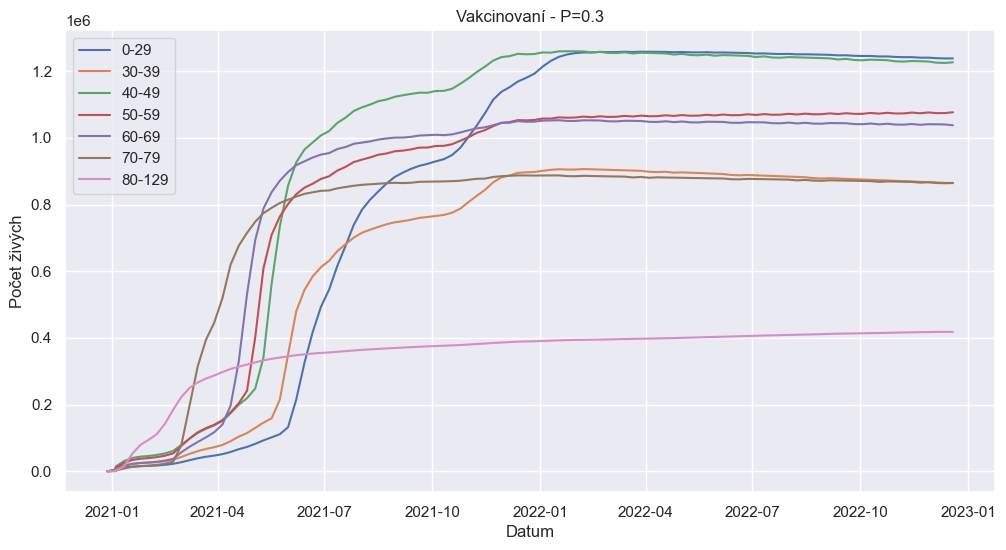

In [127]:
plt.figure(figsize=(12, 6))
for age, values in y_death_vaccinated_alive.items():
    plt.plot(x, values, label=age)

plt.ylabel("Počet živých")
plt.xlabel("Datum")
plt.title(f"Vakcinovaní - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_alive_vaccinated.png");

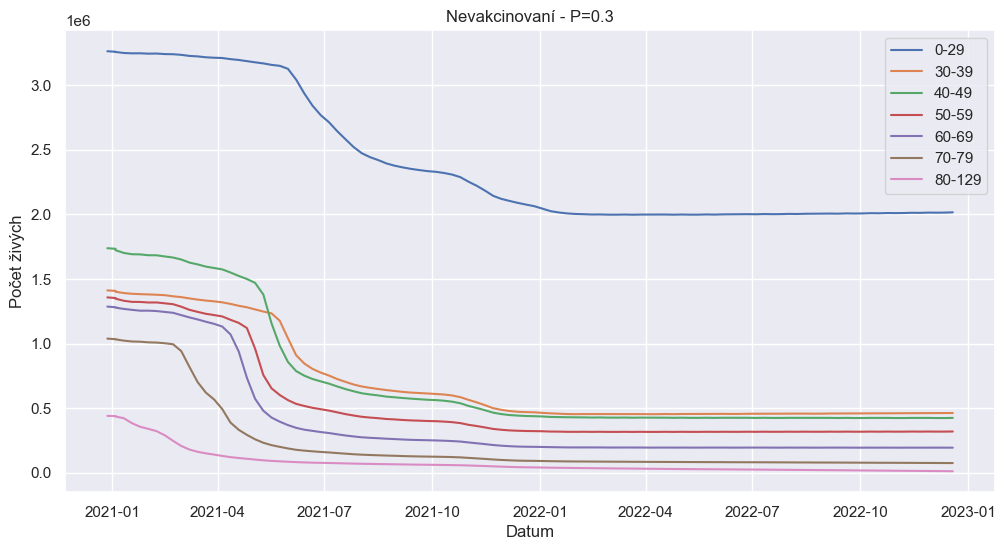

In [129]:
plt.figure(figsize=(12, 6))
for age, values in y_death_normal_alive.items():
    plt.plot(x, values, label=age)

plt.ylabel("Počet živých")
plt.xlabel("Datum")
plt.title(f"Nevakcinovaní - {P=}")
plt.legend()
plt.savefig(f"result/P_{P}_alive_normal.png");